In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
import datetime as dt

from copy import deepcopy

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn import linear_model

# used to calculate AUROC/accuracy
from sklearn import metrics

# local utils
import utils

import xgboost as xgb

import pickle

# default colours/marker/linestyles for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

/home/alistairewj/.virtualenvs/icu-model-transfer/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

In [3]:
print('=== MIMIC ===')
X_mimic = pd.read_csv('X_mimic_day1.csv.gz', sep=',', index_col=0)

var_other = ['hospitalid', 'death', 'hosp_los', 'ventdays']
df_mimic = X_mimic[var_other]

# convenient reference to death column
y_mimic = X_mimic['death'].values
X_mimic = X_mimic.drop(var_other,axis=1).values

print('{:5s} - {} observations. Outcome rate: {:2.2f}%.'.format(
        'mimic', X_mimic.shape[0], 100.0*np.mean(y_mimic)))

print('=== eICU ===')
X_eicu = pd.read_csv('X_eicu_day1.csv.gz', sep=',', index_col=0)

hosp_to_keep = X_eicu['hospitalid'].value_counts()
hosp_to_keep = hosp_to_keep[hosp_to_keep>=100].index.values
print('Retaining {} of {} hospitals.'.format(len(hosp_to_keep), X_eicu['hospitalid'].nunique()))

X_eicu = X_eicu.loc[X_eicu['hospitalid'].isin(hosp_to_keep), :]

var_other = ['hospitalid', 'death', 'hosp_los', 'ventdays']
df_eicu = X_eicu[var_other]

# convenient reference to death column
y_eicu = X_eicu['death'].values
X_eicu = X_eicu.drop(var_other,axis=1).values

print('{:5s} - {} observations. Outcome rate: {:2.2f}%.'.format(
        'eICU', X_eicu.shape[0], 100.0*np.mean(y_eicu)))

=== MIMIC ===
mimic - 27940 observations. Outcome rate: 9.57%.
=== eICU ===
Retaining 119 of 179 hospitals.
eICU  - 67540 observations. Outcome rate: 7.47%.


## Logistic Regression

In [4]:
if os.path.exists('lr_mdl.pkl'):
    with open('lr_mdl.pkl', 'rb') as fp:
        lr_mdl = pickle.load(fp)
else:
    np.random.seed(71017)

    X = X_mimic
    y = y_mimic

    base_mdl = linear_model.LogisticRegressionCV(Cs=10, penalty='l2', cv=5)

    estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ('model', base_mdl)]) 

    # train model
    lr_mdl = estimator.fit(X, y)
    lr_prob = estimator.predict_proba(X)[:,1]
    auc = metrics.roc_auc_score(y, lr_prob)
    print('Training set AUROC: {:0.3f}'.format(auc))
    with open('lr_mdl.pkl', 'wb') as fp:
        pickle.dump(lr_mdl, fp)

## Evaluate model on eICU

In [23]:
def hospital_stats(x, outcome='death'):
    d = {}
    # calculate SMR
    d['count'] = x[outcome].count()
    d['outcome'] = x[outcome].sum()
    
    d['smr'] = x[outcome].sum() / x['prob'].sum()
    if len(np.unique(x[outcome]))<=1:
        d['auc'] = np.nan
    else:
        d['auc'] = metrics.roc_auc_score(x[outcome], x['prob'])
    return pd.Series(d)

In [24]:
lr_prob = lr_mdl.predict_proba(X_eicu)[:,1]

# add predictions to dataframe
df_eicu['prob'] = lr_prob

# scatter plot grouped by hospital
h_stats = df_eicu.groupby('hospitalid').apply(hospital_stats)

# overall auroc
auc = metrics.roc_auc_score(df_eicu['death'], df_eicu['prob'])
print('eICU overall AUROC: {:0.3f}'.format(auc))
print('eICU overall SMR:   {:0.3f}'.format(df_eicu['death'].sum() / df_eicu['prob'].sum()))

eICU overall AUROC: 0.828
eICU overall SMR:   3.432


### Loop through eICU hospitals and re-train

In [32]:
# select hospitals with at least 500 patients
hosp_list = df_eicu['hospitalid'].value_counts()
hosp_list = hosp_list[hosp_list>=500].index.values

In [44]:
np.random.seed(345)


# parameters from grid search
models = {'l2': linear_model.LogisticRegressionCV(n_jobs=4),
          'xgb': xgb.XGBClassifier(colsample_bytree=0.7, silent=1,
                            learning_rate=0.01, n_estimators=1000,
                            subsample=0.8, max_depth=9, n_jobs=4)
         }

# choose a model
mdl = 'l2'
K = 5
hospital_auroc = dict()
hospital_smr = dict()

for i, h in enumerate(hosp_list):
    idxKeep = df_eicu['hospitalid'] == h
    
    hospital_auroc[h] = list()
    hospital_smr[h] = list()
    
    # get current hosp data
    X = X_eicu[idxKeep, :]
    y = y_eicu[idxKeep]
    
    idxK = np.random.permutation(X.shape[0])
    idxK = idxK % K

    if mdl == 'xgb':
        # no pre-processing of data necessary for xgb
        estimator = Pipeline([(mdl, models[mdl])])

    else:
        estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])]) 
    
    curr_prob_all = np.zeros(X.shape[0])
    for k in range(K):
        # train the model using all but the kth fold
        curr_mdl = sklearn.base.clone(estimator).fit(X[idxK != k, :], y[idxK != k])

        # get prediction on this dataset
        if mdl in ('lasso','ridge'):
            curr_prob = curr_mdl.predict(X[idxK == k, :])
        else:
            curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
            curr_prob = curr_prob[:,1]

        curr_prob_all[idxK==k] = curr_prob
        
        # calculate score (AUROC)
        curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

        # add score to list of scores
        hospital_auroc[h].append(curr_score)

        # also get SMR
        hospital_smr[h].append(np.sum(y[idxK == k]) / np.sum(curr_prob))

    print('{} - Finished {} of {}. AUROC {:0.3f}.'.format(
        dt.datetime.now(), i+1, len(hosp_list), np.mean(hospital_auroc[h])))

2018-04-20 16:41:41.028022 - Finished 1 of 46. AUROC 0.851.
2018-04-20 16:41:45.078267 - Finished 2 of 46. AUROC 0.839.
2018-04-20 16:41:48.789925 - Finished 3 of 46. AUROC 0.849.
2018-04-20 16:41:52.445601 - Finished 4 of 46. AUROC 0.887.
2018-04-20 16:41:55.957584 - Finished 5 of 46. AUROC 0.857.
2018-04-20 16:41:59.799819 - Finished 6 of 46. AUROC 0.887.
2018-04-20 16:42:02.618941 - Finished 7 of 46. AUROC 0.810.
2018-04-20 16:42:06.929513 - Finished 8 of 46. AUROC 0.867.
2018-04-20 16:42:10.214601 - Finished 9 of 46. AUROC 0.830.
2018-04-20 16:42:13.889505 - Finished 10 of 46. AUROC 0.874.
2018-04-20 16:42:17.972457 - Finished 11 of 46. AUROC 0.874.
2018-04-20 16:42:21.797282 - Finished 12 of 46. AUROC 0.839.
2018-04-20 16:42:25.223623 - Finished 13 of 46. AUROC 0.797.
2018-04-20 16:42:28.842934 - Finished 14 of 46. AUROC 0.851.
2018-04-20 16:42:33.178381 - Finished 15 of 46. AUROC 0.850.
2018-04-20 16:42:37.004386 - Finished 16 of 46. AUROC 0.723.
2018-04-20 16:42:40.726427 - Fini

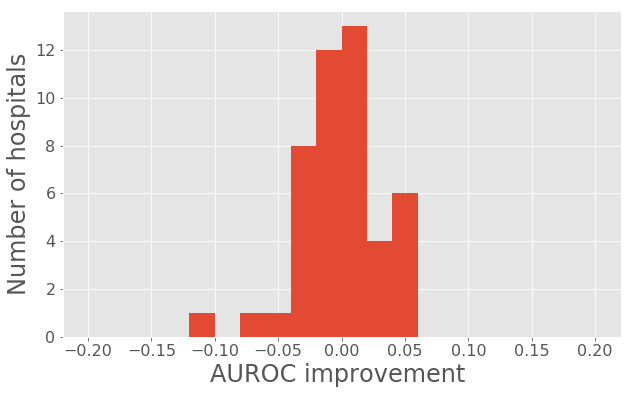

In [47]:
df_h = pd.DataFrame.from_dict(hospital_auroc,orient='index')
df_h.columns = ['auc0', 'auc1','auc2','auc3','auc4']
df_h['auc_cv'] = df_h.mean(axis=1)

df_h = df_h.merge(h_stats, how='inner', left_index=True, right_index=True)

# create a histogram
plt.figure(figsize=[10,6])
plt.hist(df_h['auc_cv'] - df_h['auc'], bins=np.linspace(-0.2, 0.2, 21))
plt.xlabel('AUROC improvement ')
plt.ylabel('Number of hospitals')
plt.show()

In [57]:
np.corrcoef(df_h['auc_cv'], df_h['count'])

array([[1.        , 0.30830412],
       [0.30830412, 1.        ]])

In [54]:
((df_h['auc_cv'] - df_h['auc'])>0).sum()

23

In [48]:
np.random.seed(5784)

# parameters from grid search
models = {'l2': linear_model.LogisticRegressionCV(n_jobs=4),
          'xgb': xgb.XGBClassifier(colsample_bytree=0.7, silent=1,
                            learning_rate=0.01, n_estimators=1000,
                            subsample=0.8, max_depth=9, n_jobs=4)
         }

# choose a model
mdl = 'l2'
K = 5

# get most frequent hospital
h_big = df_eicu['hospitalid'].value_counts()
h_big = h_big.idxmax()

# train model on top h
idxKeep = df_eicu['hospitalid'] == h_big

# get current hosp data
X = X_eicu[idxKeep, :]
y = y_eicu[idxKeep]


if mdl == 'xgb':
    # no pre-processing of data necessary for xgb
    estimator = Pipeline([(mdl, models[mdl])])

else:
    estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  (mdl, models[mdl])])

# get prediction on this dataset
curr_mdl = sklearn.base.clone(estimator).fit(X, y)

hospital_auroc_s = dict()
hospital_smr_s = dict()

# now apply to all other hospitals
for i, h in enumerate(hosp_list):
    idxKeep = df_eicu['hospitalid'] == h
    
    # get current hosp data
    X = X_eicu[idxKeep, :]
    y = y_eicu[idxKeep]
    
    # get prediction on this dataset
    if mdl in ('lasso','ridge'):
        curr_prob = curr_mdl.predict(X)
    else:
        curr_prob = curr_mdl.predict_proba(X)
        curr_prob = curr_prob[:,1]
        
    # calculate score (AUROC)
    curr_score = metrics.roc_auc_score(y, curr_prob)

    # add score to list of scores
    hospital_auroc_s[h] = curr_score

    # also get SMR
    hospital_smr_s[h] = np.sum(y) / np.sum(curr_prob)

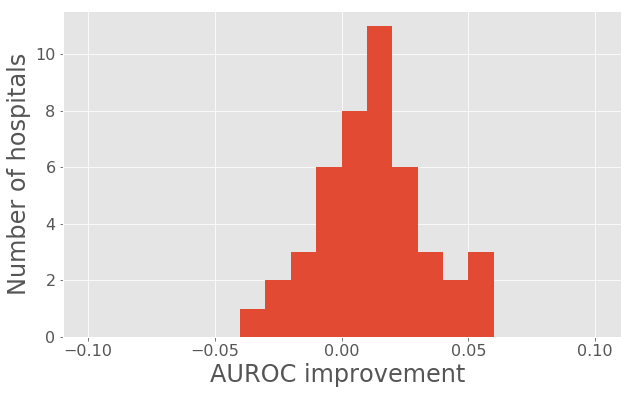

In [46]:
df_h_s = pd.DataFrame.from_dict(hospital_auroc_s,orient='index')
df_h_s.columns = ['auc_cv']

df_h_s = df_h_s.merge(h_stats, how='inner', left_index=True, right_index=True)
df_h_s.drop(h_big,axis=0,inplace=True)
# create a histogram
plt.figure(figsize=[10,6])
plt.hist(df_h_s['auc_cv'] - df_h_s['auc'], bins=np.linspace(-0.1, 0.1, 21))
plt.xticks(np.linspace(-0.1, 0.1, 5))
plt.xlabel('AUROC improvement ')
plt.ylabel('Number of hospitals')
plt.show()

In [62]:
((df_h_s['auc_cv'] - df_h_s['auc'])>0).mean()

0.7333333333333333

In [63]:
((df_h_s['auc_cv'] - df_h_s['auc'])).mean()

0.013152075571310921

In [60]:
np.corrcoef(df_h_s['auc_cv'], df_h_s['count'])

array([[1.        , 0.17036971],
       [0.17036971, 1.        ]])

## Save cross-validation performance to file

In [4]:
with open('model-performance-cv.csv', 'w') as fp:
    fp.write('{},{},{}\n'.format('model','auc','smr'))
    for mdl in results_val:
        fp.write('{}'.format(mdl))
        fp.write(',{}'.format(np.mean(results_val[mdl])))
        fp.write(',{}'.format(np.mean(smr_val[mdl])))
        fp.write('\n')